In [2]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

BASE_DATA_PATH = 'data/HandLocalization/'
TRAIN_DATAPATH = os.path.join(BASE_DATA_PATH, 'train_dataset')
TEST_DATAPATH = os.path.join(BASE_DATA_PATH, 'test_dataset')
TRAIN_IMAGES_DATAPATH = os.path.join(TRAIN_DATAPATH, 'images')
TRAIN_LABELS_DATAPATH = os.path.join(TRAIN_DATAPATH, 'annotations')
TEST_IMAGES_DATAPATH = os.path.join(TEST_DATAPATH, 'images')
TEST_LABELS_DATAPATH = os.path.join(TEST_DATAPATH, 'annotations')

In [3]:
NB_TRAIN = len(os.listdir(TRAIN_IMAGES_DATAPATH))
NB_TEST = len(os.listdir(TEST_IMAGES_DATAPATH))

assert NB_TRAIN == len(os.listdir(TRAIN_LABELS_DATAPATH))
assert NB_TEST == len(os.listdir(TEST_LABELS_DATAPATH))

print("Number of train images:", NB_TRAIN)
print("Number of test images:", NB_TEST)

Number of train images: 4069
Number of test images: 821


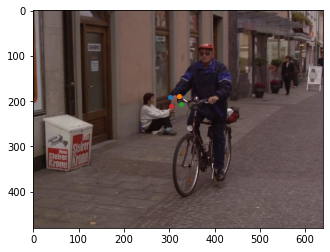

In [5]:
INDEX = 948

FIRST_LABEL_PATH = os.path.join(TRAIN_LABELS_DATAPATH, os.listdir(TRAIN_LABELS_DATAPATH)[INDEX])
first_label_file = scipy.io.loadmat(FIRST_LABEL_PATH)
first_boxes = first_label_file.get('boxes')

FIRST_IMAGE_PATH = os.path.join(TRAIN_IMAGES_DATAPATH, os.listdir(TRAIN_IMAGES_DATAPATH)[INDEX])
img = mpimg.imread(FIRST_IMAGE_PATH)
imgplot = plt.imshow(img)
x_coord = first_boxes[0][0][0][0][0][0][1]
y_coord = first_boxes[0][0][0][0][0][0][0]
plt.scatter(x_coord, y_coord, s=15)
plt.scatter(first_boxes[0][0][0][0][1][0][1], first_boxes[0][0][0][0][1][0][0], s=15)
plt.scatter(first_boxes[0][0][0][0][2][0][1], first_boxes[0][0][0][0][2][0][0], s=15)
plt.scatter(first_boxes[0][0][0][0][3][0][1], first_boxes[0][0][0][0][3][0][0], s=15)
plt.show()
#
# imgplot = plt.imshow(img)
# x_coord = first_boxes[0][1][0][0][0][0][1]
# y_coord = first_boxes[0][1][0][0][0][0][0]
# plt.scatter(x_coord, y_coord, s=15)
# plt.scatter(first_boxes[0][1][0][0][1][0][1], first_boxes[0][1][0][0][1][0][0], s=15)
# plt.scatter(first_boxes[0][1][0][0][2][0][1], first_boxes[0][1][0][0][2][0][0], s=15)
# plt.scatter(first_boxes[0][1][0][0][3][0][1], first_boxes[0][1][0][0][3][0][0], s=15)
# plt.show()

In [6]:
def get_xmin_xmax_ymin_ymax(coords):
    x_min, y_min = 10000, 10000
    x_max, y_max = 0, 0
    for coord in coords:
        try:
            x = coord[0][1]
            y = coord[0][0]
        except IndexError:
            raise IndexError("Index error for coordinates:", coord)
        if not isinstance(x, float):
            raise TypeError(f'Warning, x coordinate: {x} is not float!')
        if not isinstance(y, float):
            raise TypeError(f'Warning, y coordinate: {y} is not float!')
        x_min = x if x < x_min else x_min
        y_min = y if y < y_min else y_min
        x_max = x if x > x_max else x_max
        y_max = y if y > y_max else y_max
    return x_min, x_max, y_min, y_max


def get_yolo_box(coords):
    x_min, x_max, y_min, y_max = get_xmin_xmax_ymin_ymax(coords)
    x_center = (x_min + x_max) / 2.
    y_center = (y_min + y_max) / 2.
    width = x_max - x_min
    height = y_max - y_min
    return x_center, y_center, width, height

In [7]:
all_label_files = os.listdir(TRAIN_LABELS_DATAPATH)
format1_label_files = all_label_files[:551]
format2_label_files = all_label_files[551:]
boxes = {}
HAND_CLASS_ID = 1

for label_file in format1_label_files:
    single_img_boxes = []
    file_path = os.path.join(TRAIN_LABELS_DATAPATH, label_file)
    mat_file = scipy.io.loadmat(file_path)
    mat_boxes = mat_file.get('boxes')[0]
    for mat_box in mat_boxes:
        mat_box = mat_box[0][0]
        x_c, y_c, w, h = get_yolo_box(mat_box)
        single_img_boxes.append(np.array([x_c, y_c, w, h, HAND_CLASS_ID]))
    boxes[label_file.replace('.mat', '')] = np.array(single_img_boxes)

for label_file in format2_label_files:
    single_img_boxes = []
    file_path = os.path.join(TRAIN_LABELS_DATAPATH, label_file)
    mat_file = scipy.io.loadmat(file_path)
    mat_boxes = mat_file.get('boxes')[0]
    for mat_box in mat_boxes:
        mat_box = mat_box[0][0].tolist()[:4]
        x_c, y_c, w, h = get_yolo_box(mat_box)
        single_img_boxes.append(np.array([x_c, y_c, w, h, HAND_CLASS_ID]))
    boxes[label_file.replace('.mat', '')] = np.array(single_img_boxes)

SAVE_FILENAME = 'training_boxes.npz'
np.savez(SAVE_FILENAME, **boxes)
print('Bounding boxes saved to file:', SAVE_FILENAME)

Bounding boxes saved to file: training_boxes.npz


In [8]:
all_label_files = os.listdir(TEST_LABELS_DATAPATH)
boxes = {}
HAND_CLASS_ID = 1

for label_file in all_label_files:
    single_img_boxes = []
    file_path = os.path.join(TEST_LABELS_DATAPATH, label_file)
    mat_file = scipy.io.loadmat(file_path)
    mat_boxes = mat_file.get('boxes')[0]
    for mat_box in mat_boxes:
        mat_box = mat_box[0][0].tolist()[:4]
        x_c, y_c, w, h = get_yolo_box(mat_box)
        single_img_boxes.append(np.array([x_c, y_c, w, h, HAND_CLASS_ID]))
    boxes[label_file.replace('.mat', '')] = np.array(single_img_boxes)

SAVE_FILENAME = 'val_boxes.npz'
np.savez(SAVE_FILENAME, **boxes)
print('Bounding boxes saved to file:', SAVE_FILENAME)

821
Bounding boxes saved to file: val_boxes.npz


First box [ 60.28494624 160.63071895  40.43064686  22.81240167   1.        ]
X 40.069622808724176 80.5002696643941
Y 149.22451812024258 172.03691978825407


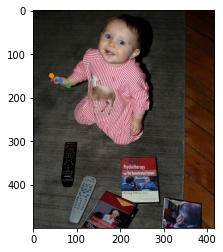

In [35]:
INDEX = 174
LABEL_PATH = os.listdir(TEST_LABELS_DATAPATH)[INDEX].replace('.mat', '')
FILENAME = 'val_boxes.npz'
labels = np.load(FILENAME, allow_pickle=True)
first_val_label = labels.get(LABEL_PATH)

first_box = first_val_label[0]
print("First box", first_box)

FIRST_VAL_IMAGE_PATH = os.path.join(TEST_IMAGES_DATAPATH, os.listdir(TEST_IMAGES_DATAPATH)[INDEX])
val_img = mpimg.imread(FIRST_VAL_IMAGE_PATH)
plt.imshow(val_img)

plt.scatter(first_box[0], first_box[1], s=15)
x_min = first_box[0] - first_box[2]/2.
x_max = first_box[0] + first_box[2]/2.
y_min = first_box[1] - first_box[3]/2.
y_max = first_box[1] + first_box[3]/2.
print("X", x_min, x_max)
print("Y", y_min, y_max)
plt.scatter(x_min, y_min, s=15)
plt.scatter(x_max, y_max, s=15)

plt.show()

LABEL PATH data/HandLocalization/test_dataset\annotations\VOC2007_101.mat
[[286.56799588 426.7171526 ]]
[[328.40259236 339.20220224]]
[[198.50063157 277.10542804]]
[[156.66603509 364.62037841]]
IMAGE PATH data/HandLocalization/test_dataset\images\VOC2007_101.jpg


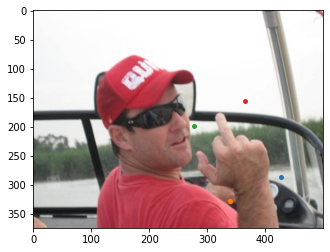

In [204]:
INDEX = 3

FIRST_LABEL_PATH = os.path.join(TEST_LABELS_DATAPATH, os.listdir(TEST_LABELS_DATAPATH)[INDEX])
print("LABEL PATH", FIRST_LABEL_PATH)
first_label_file = scipy.io.loadmat(FIRST_LABEL_PATH)
first_boxes = first_label_file.get('boxes')[0]
print(first_boxes[0][0][0][0])
print(first_boxes[0][0][0][1])
print(first_boxes[0][0][0][2])
print(first_boxes[0][0][0][3])

FIRST_IMAGE_PATH = os.path.join(TEST_IMAGES_DATAPATH, os.listdir(TEST_IMAGES_DATAPATH)[INDEX])
print("IMAGE PATH", FIRST_IMAGE_PATH)
img = mpimg.imread(FIRST_IMAGE_PATH)
imgplot = plt.imshow(img)
x_coord = first_boxes[0][0][0][0][0][1]
y_coord = first_boxes[0][0][0][0][0][0]
plt.scatter(x_coord, y_coord, s=15)
plt.scatter(first_boxes[0][0][0][1][0][1], first_boxes[0][0][0][1][0][0], s=15)
plt.scatter(first_boxes[0][0][0][2][0][1], first_boxes[0][0][0][2][0][0], s=15)
plt.scatter(first_boxes[0][0][0][3][0][1], first_boxes[0][0][0][3][0][0], s=15)
plt.show()

In [10]:
INDEX = 3
all_label_files = os.listdir(TEST_LABELS_DATAPATH)
label_file = all_label_files[3]

file_path = os.path.join(TEST_LABELS_DATAPATH, label_file)
mat_file = scipy.io.loadmat(file_path)
mat_boxes = mat_file.get('boxes')[0]
for mat_box in mat_boxes:
    mat_box = mat_box[0][0].tolist()[:4]
    x_c, y_c, w, h = get_yolo_box(mat_box)
    print(x_c, y_c, w, h)
    break


351.9112903225806 242.5343137254902 149.61172455838835 171.73655726425608
